In [300]:
%reload_ext autoreload
%autoreload 2
# imports
import os
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import ipywidgets as widgets

import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [301]:
import helpers


movies,characters = helpers.import_movies_data("./data")


/Users/antoineschutz/Desktop/adaZalixM3/helpers.py:73: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  movies["year_released"] = pd.to_datetime(


# Leading Actors Impact on Movies Ratings
- This section investigate the impact of the cast on Movie ratings
- It will also look at the evolution of ratings for actors

## Data Preprocessing 

In [302]:
print(movies.isna().sum())

print(characters.isna().sum())

wikipedia_movie_ID              0
freebase_movie_ID               0
movie_name                      0
movie_release_date              0
movie_box_office_revenue    11289
movie_runtime                 760
movie_languages                 0
movie_countries                 0
movie_genres                    0
year_released                   0
tconst                          0
averageRating                   0
numVotes                        0
dtype: int64
wikipedia_movie_ID                      0
freebase_movie_ID                       0
last_update                          9995
character_name                     257875
actor_DOB                          106145
actor_gender                        45609
actor_height                       295845
actor_ethnicity                    344611
actor_name                           1228
actor_age_at_movie_release         158113
freebase_character/actor_map_ID         0
freebase_character_ID              257865
freebase_actor_ID                     815

We need actors to be identifiable , so we have to drop rows without freebase_actor_ID  

In [303]:
characters = characters[characters["freebase_actor_ID"].notna()]


In [304]:
Movies_characters_merge = pd.merge(movies,characters,on=["wikipedia_movie_ID", "freebase_movie_ID"])


Movies_characters_merge.head(5)



,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


Now , we need to make sure that an actor appears only once in a Movie

In [305]:
dup = Movies_characters_merge[Movies_characters_merge.duplicated(subset=["wikipedia_movie_ID","freebase_actor_ID"],keep=False)]
dup.head(5)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
45,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,...,Bert,1925-12-13,M,1.85,/m/07mqps,Dick Van Dyke,38.0,/m/0k0gyy,/m/05gkznp,/m/01vb403
47,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,...,Mr. Dawes Senior,1925-12-13,M,1.85,/m/07mqps,Dick Van Dyke,38.0,/m/0h12l69,/m/0h12l6c,/m/01vb403
534,6004372,/m/0fk60h,Grace of My Heart,1996-09-08,617632.0,116.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/09glv8x"": ""Film \u00e0 clef"", ""/m/04xvlr""...",1996,...,Denise Waverly,1965-07-25,F,1.74,NaN,Illeana Douglas,31.0,/m/0jyzlg,/m/0h5m7zm,/m/01pg1d
535,6004372,/m/0fk60h,Grace of My Heart,1996-09-08,617632.0,116.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/09glv8x"": ""Film \u00e0 clef"", ""/m/04xvlr""...",1996,...,Edna Buxton,1965-07-25,F,1.74,NaN,Illeana Douglas,31.0,/m/0hmzb_v,/m/0hmzb_y,/m/01pg1d
735,20694087,/m/051w_vb,Kanden Kadhalai,2009-10-30,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film"", ""/m/01z4y"": ""Com...",2009,...,Mayil Vaganam,1953-06-04,M,NaN,/m/0dryh9k,Manobala,56.0,/m/0hb4c_j,/m/0hb4czd,/m/06zmg7m


Exemple : In the movie Mary poppins the actor Dick Van Dyke plays Bert and Mr. Dawes Senior	

In [306]:
Movies_characters_merge = Movies_characters_merge.drop_duplicates(subset=["wikipedia_movie_ID","freebase_actor_ID"])
print("We have",Movies_characters_merge.shape[0],"Combinations of Movies+actor")

We have 105389 Combinations of Movies+actor


In [307]:
unique_movies = len(Movies_characters_merge["freebase_movie_ID"].unique())
unique_actors = len(Movies_characters_merge["freebase_actor_ID"].unique())


print("There are",unique_movies,"unique movies and",unique_actors,"unique actors")



There are 12570 unique movies and 46250 unique actors


### Numbers of Actors in movies , and Number of Movies played by actors

count    46250.000000
mean         2.278681
std          3.261078
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        100.000000
Name: Number_of_Movies, dtype: float64
1.0


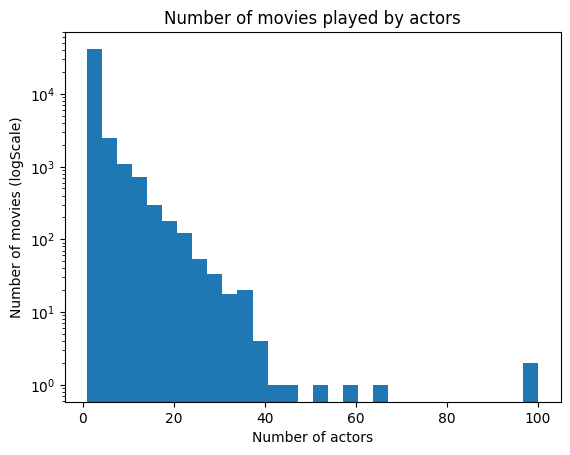

In [308]:
import matplotlib.pyplot as plt

actor_movies_count = Movies_characters_merge.groupby("freebase_actor_ID")["freebase_movie_ID"].nunique().reset_index()
actor_movies_count.columns = ['Actor_id', 'Number_of_Movies']



print(actor_movies_count['Number_of_Movies'].describe())

print(actor_movies_count['Number_of_Movies'].quantile(0.65))


plt.hist(actor_movies_count['Number_of_Movies'],bins=30,log=True)
plt.title("Number of movies played by actors")
plt.xlabel("Number of actors")
plt.ylabel("Number of movies (logScale)")
plt.show()

### Comment

We can see that most actors in the dataset played in only 1 Movies.

In order to do our analysis , we need to keep actors that played in multiple Movies.

count    12570.000000
mean         8.384169
std          6.080858
min          1.000000
25%          3.000000
50%          8.000000
75%         12.000000
max        115.000000
Name: Number_of_actors, dtype: float64


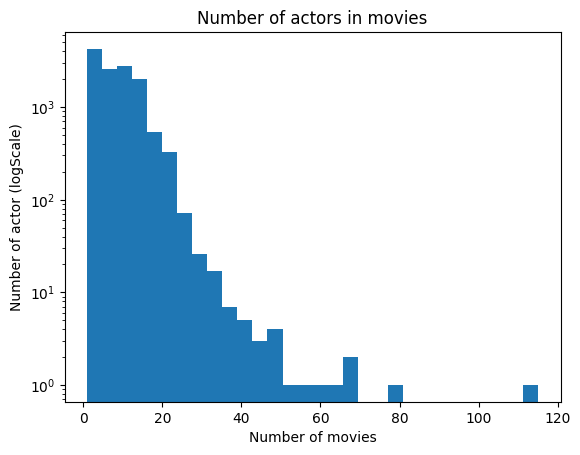

In [309]:
movies_actor_count = Movies_characters_merge.groupby("freebase_movie_ID")["freebase_actor_ID"].nunique().reset_index()
movies_actor_count.columns = ['Movies_id', 'Number_of_actors']



print(movies_actor_count['Number_of_actors'].describe())




plt.hist(movies_actor_count['Number_of_actors'],bins=30,log=True)
plt.title("Number of actors in movies")
plt.xlabel("Number of movies")
plt.ylabel("Number of actor (logScale)")
plt.show()

### Comment

We see that there are 8 actors on average on a Movie.

# Filtering Actors with Not enough Films

In [310]:
actors_with_at_least_10_movies = actor_movies_count[actor_movies_count.Number_of_Movies>10]
actors_with_at_least_20_movies = actor_movies_count[actor_movies_count.Number_of_Movies>20]
actors_with_at_least_35_movies = actor_movies_count[actor_movies_count.Number_of_Movies>35] 



print("There are ",actors_with_at_least_10_movies.shape[0],"actors with at least 10 films, and ",actors_with_at_least_20_movies.shape[0],"actors with at least 20 films")



Movies_characters_merge_10movies = Movies_characters_merge[Movies_characters_merge["freebase_actor_ID"].isin(actors_with_at_least_10_movies.Actor_id.values)]
Movies_characters_merge_20movies = Movies_characters_merge[Movies_characters_merge["freebase_actor_ID"].isin(actors_with_at_least_20_movies.Actor_id.values)]
Movies_characters_merge_35movies = Movies_characters_merge[Movies_characters_merge["freebase_actor_ID"].isin(actors_with_at_least_35_movies.Actor_id.values)]




#Sanity check : 
unique_actors_10 = len(Movies_characters_merge_10movies["freebase_actor_ID"].unique())
unique_actors_20 = len(Movies_characters_merge_20movies["freebase_actor_ID"].unique())
unique_actors_30 = len(Movies_characters_merge_35movies["freebase_actor_ID"].unique())

unique_actors_10,unique_actors_20,unique_actors_30

There are  1450 actors with at least 10 films, and  260 actors with at least 20 films


(1450, 260, 18)

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.05
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           0.000890
Time:                        12:39:58   Log-Likelihood:                -9012.7
No. Observations:                7014   AIC:                         1.803e+04
Df Residuals:                    7012   BIC:                         1.804e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.7147      0.705     12.369

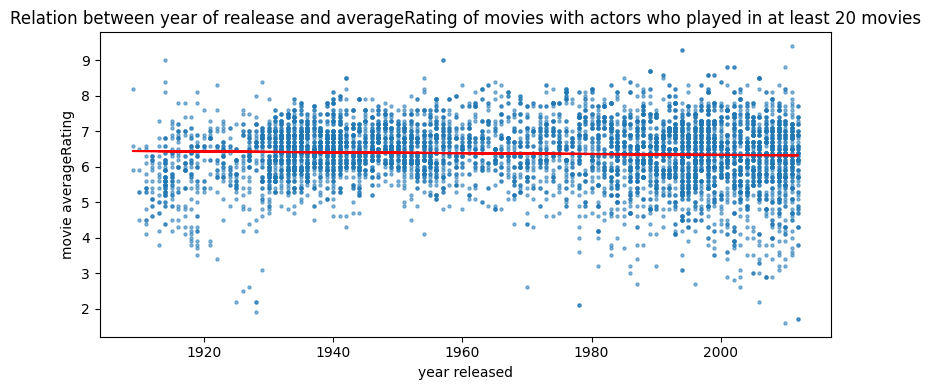

In [311]:
#perform linear regression on duration data, and plot the regression line
model=smf.ols(formula='averageRating ~ year_released', data=Movies_characters_merge_20movies)
results=model.fit()
print(results.summary())

plt.figure(figsize=(8, 4))
plt.scatter(Movies_characters_merge_20movies["year_released"], Movies_characters_merge_20movies["averageRating"], alpha=0.5, s=5)

plt.plot(Movies_characters_merge_20movies["year_released"], results.predict(), color="red")
plt.title("Relation between year of realease and averageRating of movies with actors who played in at least 20 movies")
plt.xlabel("year released")
plt.ylabel("movie averageRating")

plt.tight_layout()


plt.show()

# Visualisation of the Evolution of ratings for 5 random actors

In [312]:
import random


actorsId_20movies = Movies_characters_merge_20movies["freebase_actor_ID"].tolist() #List all actors that played in at least 20 movies
selected_actors = random.sample(actorsId_20movies, k=5) #Select 5 actors out of that list


Movies_characters_selected = Movies_characters_merge_20movies[Movies_characters_merge_20movies["freebase_actor_ID"].isin(selected_actors)] #


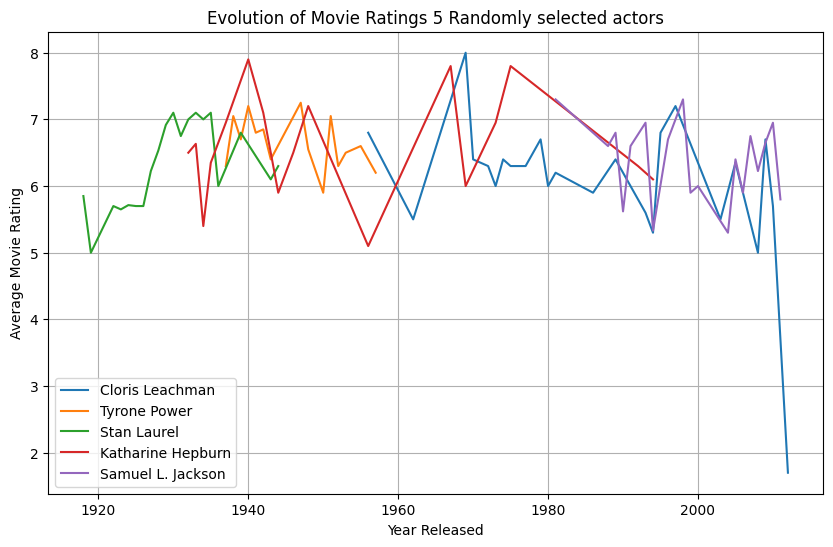

In [313]:
average_ratings_by_actor_year = Movies_characters_selected.groupby(['freebase_actor_ID','actor_name', 'year_released'])['averageRating'].mean().reset_index()

# Plotting the evolution of movie ratings across the years for all actors
plt.figure(figsize=(10, 6))

# Iterate through each actor, calculate their ratings over the years, and plot
for actor_id, actor_group in average_ratings_by_actor_year.groupby(['freebase_actor_ID',"actor_name"]):
    plt.plot(actor_group['year_released'], actor_group['averageRating'], label=actor_id[1])

# Set plot labels and title
plt.xlabel('Year Released')
plt.ylabel('Average Movie Rating')
plt.title('Evolution of Movie Ratings 5 Randomly selected actors')
plt.legend()  # Show legend with actor IDs

# Show the plot
plt.grid(True)
plt.show()

## Relation between year of realease and averageRating for actors with at least 20 movies

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.006
Date:                Sat, 16 Dec 2023   Prob (F-statistic):             0.0842
Time:                        12:39:59   Log-Likelihood:                -63.412
No. Observations:                 260   AIC:                             130.8
Df Residuals:                     258   BIC:                             137.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.85

Text(0, 0.5, 'movie averageRating')

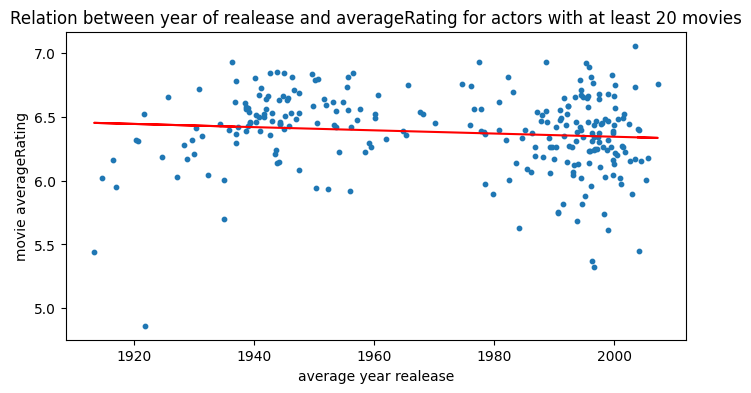

In [314]:
best_actors = Movies_characters_merge_20movies.groupby(["freebase_actor_ID","actor_name"]).agg({
    'averageRating': 'mean',
    'year_released': 'mean'
}).reset_index()

best_actors.sort_values(by="averageRating",ascending=False)

best_actors.columns=["freebase_actor_ID","actor_name","averageRating","average_year_realease"]

model=smf.ols(formula='averageRating ~ average_year_realease', data=best_actors)
results=model.fit()
print(results.summary())

plt.figure(figsize=(8, 4))
plt.scatter(best_actors["average_year_realease"], best_actors["averageRating"],s=10)

plt.plot(best_actors["average_year_realease"], results.predict(), color="red")
plt.title("Relation between year of realease and averageRating for actors with at least 20 movies")
plt.xlabel("average year realease")
plt.ylabel("movie averageRating")

In [315]:
Movies_characters_merge_20movies

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
17,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,...,Cop,1887-03-24,M,1.78,/m/07bch9,Roscoe Arbuckle,NaN,/m/040l8c4,/m/0h5km4p,/m/0k57l
19,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,...,Roger Grant AKA Alexander,1914-05-05,M,1.82,/m/06v41q,Tyrone Power,24.0,/m/02vbvj2,/m/0h36wrs,/m/02s58t
54,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,...,Admiral Boom,1887-08-05,M,NaN,NaN,Reginald Owen,NaN,/m/0csl6kq,/m/0h5njw2,/m/0b47ns
79,7028314,/m/0h10pz,The Little Hut,1957-05-03,3600000.0,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1957,...,NaN,1910-03-01,M,1.83,/m/03lmx1,David Niven,47.0,/m/02vb8sf,NaN,/m/0f2df
91,2154704,/m/06qv1c,Choke Canyon,1986-05-02,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0cq22f9"": ""Actio...",1986,...,Brook Alastair,1940-05-05,M,1.78,/m/0cnvdq1,Lance Henriksen,45.0,/m/05t6mpf,/m/0j7370s,/m/02zhkz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106144,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",1988,...,Hold-Up Man,1948-12-21,M,1.89,/m/0x67,Samuel L. Jackson,39.0,/m/04d4gc1,/m/0gy9d5j,/m/0f5xn
106148,22330502,/m/05sync6,Inspiration,1931-01-31,NaN,74.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1931,...,NaN,1879-11-15,M,NaN,NaN,Lewis Stone,NaN,/m/05tg4vh,NaN,/m/011_r9
106150,22330502,/m/05sync6,Inspiration,1931-01-31,NaN,74.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1931,...,NaN,1904-05-21,M,NaN,NaN,Robert Montgomery,26.0,/m/05tg4vn,NaN,/m/034cj9
106153,24997872,/m/09g6klx,Pokkiri Raja,2010-05-07,NaN,136.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}",2010,...,Raja,1951-09-07,M,1.78,/m/04mvp8,Mammootty,58.0,/m/0gvytkx,/m/0h27wx_,/m/02hkv5


We Want to see if Star Power Translate to Higher ratings , For this , we will perform a linear Regression over actors with at least 20 movies to see how well they explain the variance in Movie Ratings.

In [317]:
Actors_with_at_least_35_movies_dummy = pd.get_dummies(data=Movies_characters_merge_35movies,columns=["freebase_actor_ID"],dtype=int)


formula = "averageRating ~ "

for ch in ['/', ' ', "'", '-']:
    Actors_with_at_least_35_movies_dummy.columns = Actors_with_at_least_35_movies_dummy.columns.str.replace(ch, "")

for col in Actors_with_at_least_35_movies_dummy.columns:
    if col.startswith("freebase_actor"):
        formula += "C("+col+")+"

formula  = formula[:-1]



model = smf.ols(formula=formula, data=Actors_with_at_least_35_movies_dummy)
res = model.fit()
res_summary = res.summary()

In [318]:
res.rsquared

0.10568121274096953

The R-squared is quite low , but the formula for the linear regression only included information about actors , and nothing about genre / runtime / budget ...

In [319]:
results_as_html = res_summary.tables[1].as_html()

# Convert to pandas DataFrames
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]


# We keep only Rows where P>|t| is <0.05 , to keep only significant data 
summary_df = summary_df[summary_df["P>|t|"]<=0.05]


# now that we only have Rows with significant data , we can sort by coef to see the most impactful actor

summary_df.sort_values(by="coef",ascending=False)

summary_df = summary_df.reset_index()
summary_df.rename(columns={'index': 'freebase_actor_ID'}, inplace=True)



summary_df = summary_df.drop(0)

#Reconverting Freebase_actor_id into the correct format 

summary_df['freebase_actor_ID'] = summary_df['freebase_actor_ID'].str.split('ID_').str[-1].str.split('\)\[T.1').str[0]

summary_df["freebase_actor_ID"] = "/m/"+summary_df["freebase_actor_ID"].str[1:]

summary_df


/var/folders/9_/z1m27wy57j34pk1k36dtbd280000gn/T/ipykernel_20569/3065806165.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]


,freebase_actor_ID,coef,std err,t,P>|t|,[0.025,0.975]
1,/m/012vf6,0.4375,0.124,3.517,0.000,0.193,0.682
2,/m/01v3bn,0.4990,0.124,4.012,0.000,0.255,0.743
3,/m/01ycbq,0.4413,0.128,3.460,0.001,0.191,0.692
4,/m/02gf_l,0.3253,0.129,2.517,0.012,0.072,0.579
5,/m/03mv0b,0.2970,0.098,3.035,0.002,0.105,0.489
6,/m/0c2tf,0.5927,0.128,4.647,0.000,0.342,0.843
7,/m/0c5vh,0.7510,0.081,9.329,0.000,0.593,0.909
8,/m/0cgbf,-0.2869,0.110,-2.619,0.009,-0.502,-0.072
9,/m/0f5xn,0.2785,0.124,2.239,0.025,0.034,0.523
10,/m/0gnbw,0.4809,0.129,3.721,0.000,0.227,0.735


In [320]:
merged_top_actors = pd.merge(summary_df,Movies_characters_merge_35movies,on="freebase_actor_ID",how="inner")
merged_top_actors.sort_values(by="coef",ascending=False)

,freebase_actor_ID,coef,std err,t,P>|t|,[0.025,0.975],wikipedia_movie_ID,freebase_movie_ID,movie_name,...,last_update,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID
498,/m/0h1m9,0.8281,0.129,6.408,0.000,0.574,1.082,16738372,/m/0b3klf,Hollywood Canteen,...,1944-12-15,NaN,1908-04-05,F,1.60,NaN,Bette Davis,36.0,/m/0h0yrv7,NaN
503,/m/0h1m9,0.8281,0.129,6.408,0.000,0.574,1.082,7722097,/m/0kvfzp,Strangers: The Story of a Mother and Daughter,...,1979-05-13,Lucy Mason,1908-04-05,F,1.60,NaN,Bette Davis,71.0,/m/03lv1cr,/m/0h0yp_z
493,/m/0h1m9,0.8281,0.129,6.408,0.000,0.574,1.082,14470369,/m/03d4lj7,The Big Shakedown,...,1934-01-06,Norma Nelson,1908-04-05,F,1.60,NaN,Bette Davis,25.0,/m/045_wp3,/m/0h0yp_9
494,/m/0h1m9,0.8281,0.129,6.408,0.000,0.574,1.082,11632165,/m/02rm5d2,The Sisters,...,1938-10-14,Louise Elliott Medlin,1908-04-05,F,1.60,NaN,Bette Davis,30.0,/m/02vcb_t,/m/0h0yqhp
495,/m/0h1m9,0.8281,0.129,6.408,0.000,0.574,1.082,12006635,/m/02vlqqh,The Dark Horse,...,1932-06-08,Kay Russell,1908-04-05,F,1.60,NaN,Bette Davis,24.0,/m/03k_ydb,/m/0h0yqhg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,/m/0cgbf,-0.2869,0.110,-2.619,0.009,-0.502,-0.072,11577317,/m/02rjv0t,This Modern Age,...,1931-08-29,Valentine 'Val' Winters,1905-03-23,F,1.65,NaN,Joan Crawford,26.0,/m/03kzs0f,/m/0gy2qyy
391,/m/0cgbf,-0.2869,0.110,-2.619,0.009,-0.502,-0.072,11567877,/m/02rjfz0,Paid,...,1930-12-30,Mary Turner,1905-03-23,F,1.65,NaN,Joan Crawford,25.0,/m/03kzrc5,/m/0gy2qfy
390,/m/0cgbf,-0.2869,0.110,-2.619,0.009,-0.502,-0.072,11594636,/m/02rkxqw,Letty Lynton,...,1932-05-14,Letty Lynton,1905-03-23,F,1.65,NaN,Joan Crawford,27.0,/m/03kztl2,/m/0gy2qt8
389,/m/0cgbf,-0.2869,0.110,-2.619,0.009,-0.502,-0.072,11635629,/m/02rm8yk,Strange Cargo,...,1940-03-01,Julie,1905-03-23,F,1.65,NaN,Joan Crawford,34.0,/m/02vc5wn,/m/0ch90d8


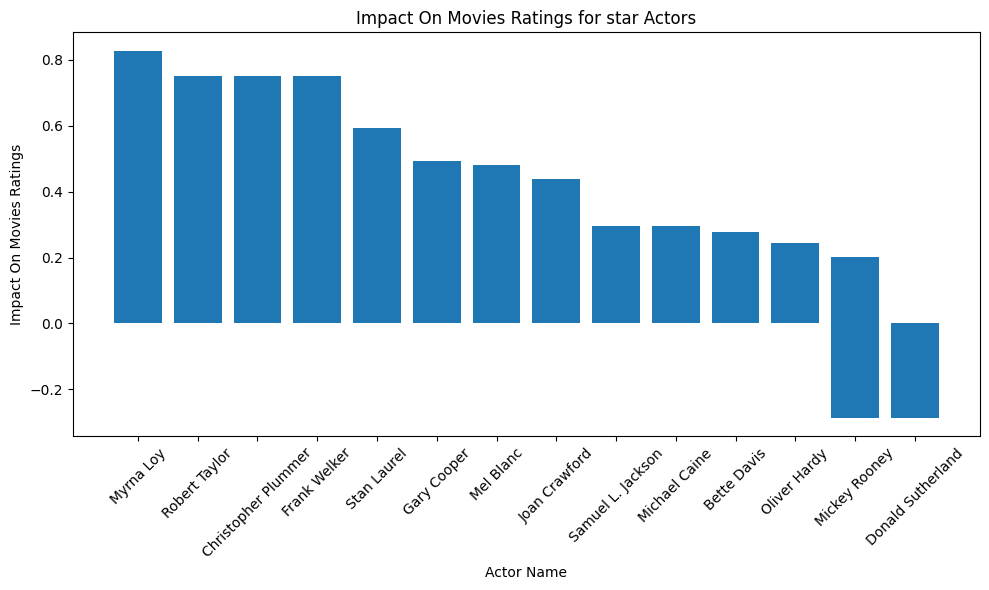

In [321]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.bar(merged_top_actors['actor_name'], merged_top_actors['coef'].sort_values(ascending=False))
plt.xlabel('Actor Name')
plt.ylabel('Impact On Movies Ratings')
plt.title('Impact On Movies Ratings for star Actors')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.tight_layout()


The graph illustrates that specific stars wield a substantial influence on movie ratings. The presence of these actors can elevate the ratings by nearly a whole point.